In [2]:
import os

os.chdir("..")
print(os.getcwd()) 

c:\Users\Jose\Desktop\git\TabularDataGAN


In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from Models import Generators

In [2]:
df = pd.read_csv("Data/Maternal Health Risk Data Set.csv")
numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df = df[numeric_cols]

scaler = MinMaxScaler()
data = scaler.fit_transform(df)  # Normalizar datos entre 0 y 1
data_dim = data.shape[1]

In [3]:
df.dropna()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,25,130,80,15.0,98.0,86
1,35,140,90,13.0,98.0,70
2,29,90,70,8.0,100.0,80
3,30,140,85,7.0,98.0,70
4,35,120,60,6.1,98.0,76
...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80
1010,55,120,90,18.0,98.0,60
1011,35,85,60,19.0,98.0,86
1012,43,120,90,18.0,98.0,70


In [6]:
# Generator of the GAN using  Bhattacharyya loss function just to try to adjust to the generated distributions.

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, output_dim),
            nn.Sigmoid()  # Ensures output is in [0,1]
        )

    def forward(self, z):
        return self.model(z)


class EncoderDecoderGenerator(nn.Module):
    def __init__(self, in_out_dim, num_layers=3, initial_neurons=256, latent_dim=None):
        """
        - in_out_dim: Input and output dimension (same for autoencoder).
        - num_layers: Number of hidden layers (excluding input, output, and latent layers).
        - initial_neurons: Number of neurons in the first hidden layer (shrinks progressively).
        - latent_dim: Dimension of the latent space (computed if None).
        """
        super(EncoderDecoderGenerator, self).__init__()

        if latent_dim is None:
            latent_dim = initial_neurons // (2 ** (num_layers - 1))
        
        # Construct Encoder
        encoder_layers = []
        for i in range(num_layers):
            if i == 0:
                encoder_layers.extend(self.custom_layer(in_out_dim, initial_neurons))
                neurons = initial_neurons
            else:
                encoder_layers.extend(self.custom_layer(neurons, neurons // 2))
                neurons //= 2

        # Add bottleneck (latent representation)
        encoder_layers.extend(self.custom_layer(neurons, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Construct Decoder
        decoder_layers = []
        neurons = latent_dim
        for _ in range(num_layers):
            decoder_layers.extend(self.custom_layer(neurons, neurons * 2))
            neurons *= 2

        # Add output layer
        decoder_layers.append(nn.Linear(neurons, in_out_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    @staticmethod
    def custom_layer(input_dim, output_dim, dropout_rate=0.1):
        """Helper function to create a single encoder/decoder layer."""
        return [
            nn.Linear(input_dim, output_dim), 
            nn.BatchNorm1d(output_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        ]

    def forward(self, x):
        latent = self.encoder(x)  # Encode input to latent representation
        output = self.decoder(latent)  # Decode back to output
        return output


# 🔹 Función de pérdida basada en la distancia de Bhattacharyya
def bhattacharyya_loss(y_pred, data_target, coef_min_th=1e-8):
    """
    Calcula la pérdida basada en la distancia de Bhattacharyya entre dos distribuciones
    con tamaños diferentes en PyTorch.
    
    Args:
        y_pred (Tensor): Predicción del modelo, tamaño [batch, features].
        data_target (Tensor): Distribución objetivo, tamaño [batch, features].
    
    Returns:
        Tensor: Valor escalar de la pérdida.
    """
    # Asegurar que las distribuciones no tengan valores negativos
    y_pred = torch.abs(y_pred)
    data_target = torch.abs(data_target)

    # Normalización para que las distribuciones sumen 1 (evita divisiones por 0 con clamp)
    p = data_target / torch.clamp(torch.sum(data_target, dim=0, keepdim=True), min=coef_min_th)
    q = y_pred / torch.clamp(torch.sum(y_pred, dim=0, keepdim=True), min=coef_min_th)

    # print("p:", p.min(), p.max())
    # print("q:", q.min(), q.max())
    
    # Calcular el coeficiente de Bhattacharyya para cada feature
    bc_coeff = torch.sum(torch.sqrt(torch.clamp(p * q, min=coef_min_th)), dim=0)

    # Evitar log(0) con torch.clamp
    loss = -torch.log(torch.clamp(bc_coeff, min=coef_min_th))

    # print(loss)
    
    # Devolver la suma de las pérdidas de cada feature
    return loss.sum()


def covariance_matrix(x):
    """
    Computes the upper-triangular values of the covariance matrix for a given 2D tensor.

    Args:
        x (torch.Tensor): Input tensor of shape [batch_size, num_features].

    Returns:
        torch.Tensor: Upper-triangular values (excluding diagonal) of the covariance matrix.
    """
    # Ensure input is 2D
    if x.dim() != 2:
        raise ValueError("Input tensor must have shape [batch_size, num_features]")

    # Compute mean and center the data
    mean_x = torch.mean(x, dim=0, keepdim=True)
    x_centered = x - mean_x

    # Compute covariance matrix
    cov_matrix = torch.mm(x_centered.T, x_centered) / (x.shape[0] - 1)

    # Extract upper triangular values (excluding diagonal)
    num_features = cov_matrix.shape[0]
    upper_indices = torch.triu_indices(num_features, num_features, offset=1)
    upper_diag_values = cov_matrix[upper_indices[0], upper_indices[1]]
    
    return upper_diag_values


def correlation_matrix(x):
    # Ensure y_pred is 2D: [batch_size, num_features]
    if x.dim() != 2:
        raise ValueError("Input tensor must have shape [batch_size, num_features]")

    mean_x = torch.mean(x, dim=0, keepdim=True)
    x_centered = x - mean_x

    cov_matrix = torch.mm(x_centered.T, x_centered) / (x.shape[0] - 1)
    std_dev = torch.sqrt(torch.diag(cov_matrix) + 1e-8)
    correlation_matrix = cov_matrix / (std_dev[:, None] * std_dev[None, :])

    num_features = correlation_matrix.shape[0]
    upper_indices = torch.triu_indices(num_features, num_features, offset=1)
    upper_diag_values = correlation_matrix[upper_indices[0], upper_indices[1]]
    
    return upper_diag_values


def autocorrelation(x, epsilon=1e-8):
    x_mean = torch.mean(x, dim=0)
    x_shifted = torch.roll(x, shifts=1, dims=0)  # Desplazar una posición
    numerator = torch.sum((x - x_mean) * (x_shifted - x_mean), dim=0)
    denominator = torch.sum((x - x_mean) ** 2, dim=0)
    return numerator / (denominator + epsilon)


def custom_loss(y_pred, data_target, method="all"):
    """
    Args:
        y_pred (Tensor): Predicción del modelo, tamaño [batch_size, num_features].
        data_target (Tensor): Distribución objetivo, tamaño [batch_size, num_features].

    Returns:
        Tensor: Valor escalar de la pérdida.
    """
    
    # Calcular las medias de las predicciones y las distribuciones objetivo
    # mean_pred = torch.mean(y_pred, dim=0)
    # mean_target = torch.mean(data_target, dim=0)

    median_pred = torch.median(y_pred, dim=0).values
    median_target = torch.median(data_target, dim=0).values

    # Calcular el rango intercuartílico (IQR)
    q1_pred = torch.quantile(y_pred, 0.25, dim=0)
    q3_pred = torch.quantile(y_pred, 0.75, dim=0)
    iqr_pred = q3_pred - q1_pred

    q1_target = torch.quantile(data_target, 0.25, dim=0)
    q3_target = torch.quantile(data_target, 0.75, dim=0)
    iqr_target = q3_target - q1_target

    autocorr_pred = autocorrelation(y_pred)
    autocorr_target = autocorrelation(data_target)
    
    # Calcular la distancia de Wasserstein como la norma L1 de las medias

    if method == "all":
        custom_loss_value = (
            # torch.sum(torch.abs(mean_pred - mean_target)) +
            torch.sum(torch.abs(median_pred - median_target)) +
            torch.sum(torch.abs(iqr_pred - iqr_target)) +
            torch.sum(torch.abs(autocorr_pred - autocorr_target)) +
            torch.sum(torch.abs(correlation_matrix(y_pred) - correlation_matrix(data_target))) + 
            torch.sum(torch.abs(covariance_matrix(y_pred) - covariance_matrix(data_target)))
        )
    else:
        custom_loss_value = 0
        if "median" in method:
            custom_loss_value += torch.sum(torch.abs(median_pred - median_target))
        if "iqr" in method:
            custom_loss_value += torch.sum(torch.abs(iqr_pred - iqr_target))
        if "autocorr" in method:
            custom_loss_value += torch.sum(torch.abs(autocorr_pred - autocorr_target))
        if "corrmat" in method:
            custom_loss_value += torch.sum(torch.abs(correlation_matrix(y_pred) - correlation_matrix(data_target)))
        if "covmat" in method:
            custom_loss_value += torch.sum(torch.abs(covariance_matrix(y_pred) - covariance_matrix(data_target)))
    
    return custom_loss_value

# generator = PINNGenerator(input_dim=data_dim, output_dim=data_dim)
generator = EncoderDecoderGenerator(in_out_dim=data_dim, latent_dim=16)
optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)

In [7]:
# correlation_matrix(real_data)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, dropout_value=0.3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increase initial size
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),  # Use LeakyReLU instead of ReLU
            nn.Dropout(dropout_value),  # Increased dropout rate
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_value),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_value),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_value),
            
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_value),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
        # Weight initialization
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)

# Optimizer with correct model parameters
discriminator = Discriminator(input_dim=data_dim)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-3)

# Loss function
criterion = nn.BCELoss()

In [9]:
num_epochs = 8000
batch_size = 64

all_real_data_torch = torch.tensor(data, dtype=torch.float32)

save_nn_data_list = []
for epoch in range(num_epochs):
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data_array = data[idx]
    real_data = torch.tensor(data[idx], dtype=torch.float32)
    
    # Generar datos falsos
    z = torch.randn(batch_size, data_dim)
    fake_data = generator(z)

    if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
        print("Fake data contains NaNs or Infs!")
        break

    if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
        print("Real data contains NaNs or Infs!")
        break
    
    # Entrenar Discriminador
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Entrenar Generador
    optimizer_g.zero_grad()
    g_loss = custom_loss(fake_data, all_real_data_torch, method="median-iqr-covmat")
    g_loss.backward()
    # g_loss.backward()
    optimizer_g.step()

    if epoch % 100 == 0:
        save_nn_data_list.append({
            "epoch": epoch,
            "discriminator_loss": d_loss.item(),
            "generator_loss": g_loss.item()
        })

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

print(f"Epoch {epoch + 1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

df_nn = pd.DataFrame(save_nn_data_list)

Epoch 0, D Loss: 1.835860013961792, G Loss: 2.7645907402038574
Epoch 500, D Loss: 1.0918400287628174, G Loss: 1.2558393478393555
Epoch 1000, D Loss: 0.5625377297401428, G Loss: 0.4831409454345703
Epoch 1500, D Loss: 0.48490989208221436, G Loss: 0.4828141927719116
Epoch 2000, D Loss: 0.2752250134944916, G Loss: 0.34177055954933167
Epoch 2500, D Loss: 0.30093830823898315, G Loss: 0.3228932023048401
Epoch 3000, D Loss: 0.3244262933731079, G Loss: 0.325215220451355
Epoch 3500, D Loss: 0.25991958379745483, G Loss: 0.3266019821166992
Epoch 4000, D Loss: 0.15725931525230408, G Loss: 0.35411548614501953
Epoch 4500, D Loss: 0.23918461799621582, G Loss: 0.49538934230804443
Epoch 5000, D Loss: 0.15591023862361908, G Loss: 0.37374743819236755
Epoch 5500, D Loss: 0.17141087353229523, G Loss: 0.28229719400405884
Epoch 6000, D Loss: 0.10297709703445435, G Loss: 0.30026906728744507
Epoch 6500, D Loss: 0.2032308727502823, G Loss: 0.28988516330718994
Epoch 7000, D Loss: 0.15841853618621826, G Loss: 0.34

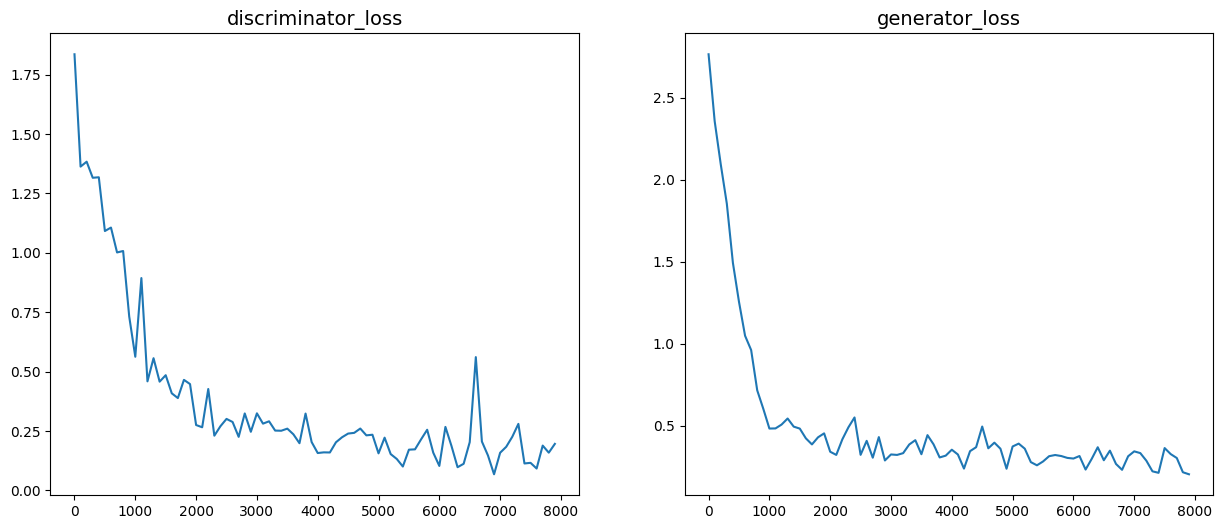

In [10]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1,2,1)
plt.plot(df_nn["epoch"], df_nn["discriminator_loss"])
plt.title("discriminator_loss", fontsize=14)

fig.add_subplot(1,2,2)
plt.plot(df_nn["epoch"], df_nn["generator_loss"])
plt.title("generator_loss", fontsize=14)

plt.show()

In [11]:
from sdv.metadata import Metadata
from sdv.evaluation.single_table import evaluate_quality

numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
metadata = Metadata.detect_from_dataframe(
    data=df[numeric_cols],
    table_name='maternal_metadata'
)

custom_metadata_dict = {
    "Age": "integer",
    "SystolicBP": "integer",
    "DiastolicBP": "integer",
    "BS": "float",
    "BodyTemp": "float",
    "HeartRate": "integer",
}

In [12]:
z = torch.randn(500, data_dim)  # Generar 5000 nuevas filas
synthetic_data = generator(z).detach().numpy()

# Denormalizar
synthetic_data = scaler.inverse_transform(synthetic_data)

# Guardar en CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
# synthetic_df.to_csv("datos_sinteticos.csv", index=False)


custom_syn_df = synthetic_df.copy()

for col_name, col_type in custom_metadata_dict.items():
    if col_type == "integer":
        custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

In [13]:
display(custom_syn_df)

corr_list = []
for i_c, i_col in enumerate(numeric_cols[:-1]):
    for j_col in numeric_cols[(i_c+1):]:
        corr_v, p_value = sp.stats.pearsonr(custom_syn_df[i_col].values, custom_syn_df[j_col].values)
        corr_list.append({
            "Feature1": i_col, "Feature2": j_col, "correlation": corr_v, "pvalue": p_value
        })

df_corr = pd.DataFrame(corr_list).sort_values("correlation", ascending=False).reset_index(drop=True)
df_corr

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,17,97,63,6.735348,98.005936,76
1,14,87,55,6.360146,98.000946,83
2,31,107,66,6.933043,98.003448,79
3,13,136,86,6.876267,98.001373,81
4,13,79,56,6.188794,98.000374,81
...,...,...,...,...,...,...
495,21,112,71,7.414216,98.012581,77
496,33,132,88,7.506820,98.008453,63
497,24,128,73,7.552339,98.009155,78
498,29,130,91,7.837309,98.003204,67


,Feature1,Feature2,correlation,pvalue
0,SystolicBP,DiastolicBP,0.880944,6.159782e-164
1,DiastolicBP,BS,0.613687,4.555816e-53
2,SystolicBP,BS,0.593976,5.309892e-49
3,Age,SystolicBP,0.588870,5.412041e-48
4,Age,BS,0.571337,1.154289e-44
5,Age,DiastolicBP,0.529385,1.843342e-37
6,BS,HeartRate,0.282574,1.240223e-10
7,Age,HeartRate,0.094166,3.528959e-02
8,BS,BodyTemp,0.005348,9.050461e-01
9,SystolicBP,BodyTemp,-0.029701,5.075686e-01


In [14]:
quality_report = evaluate_quality(
    df[numeric_cols],
    synthetic_df,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 234.96it/s]|
Column Shapes Score: 68.99%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 162.03it/s]|
Column Pair Trends Score: 93.03%

Overall Score (Average): 81.01%



In [15]:
quality_report = evaluate_quality(
    df[numeric_cols],
    custom_syn_df,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 335.96it/s]|
Column Shapes Score: 69.39%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 219.08it/s]|
Column Pair Trends Score: 93.04%

Overall Score (Average): 81.21%



In [16]:
quality_report.get_score()

np.float64(0.8121368874629391)

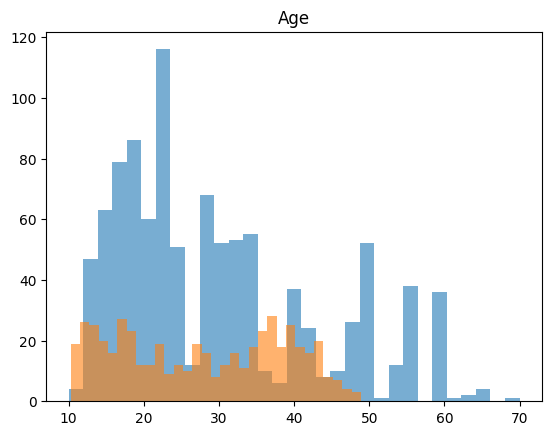

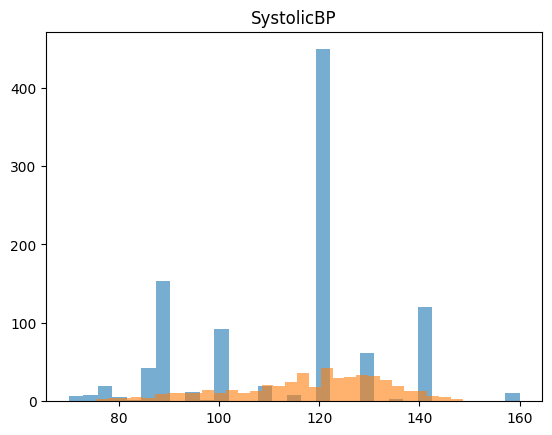

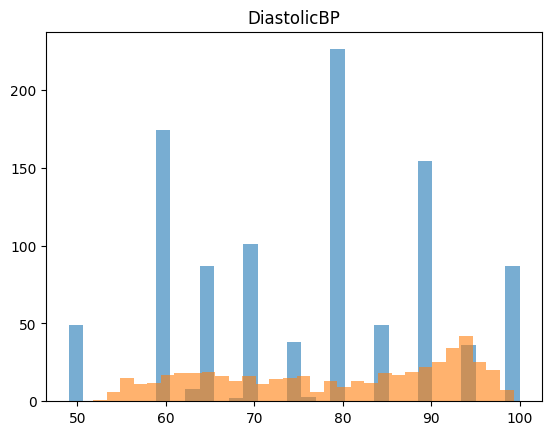

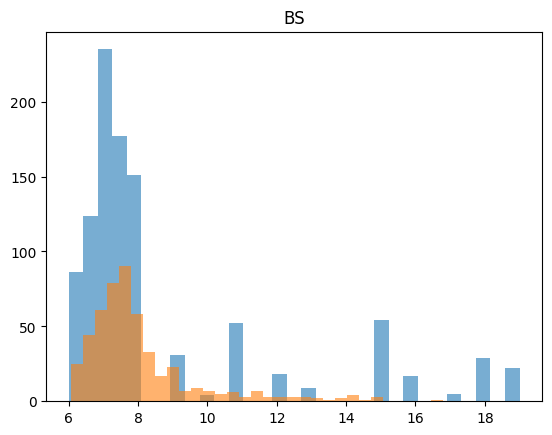

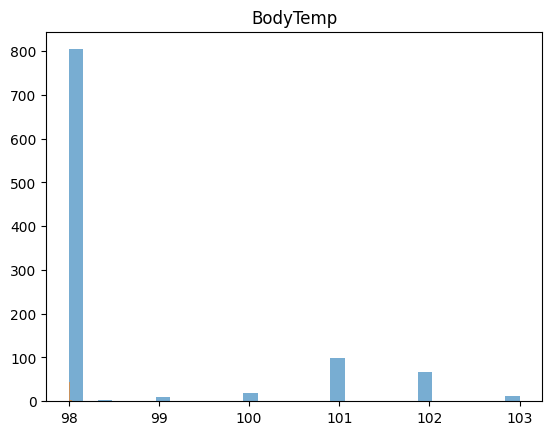

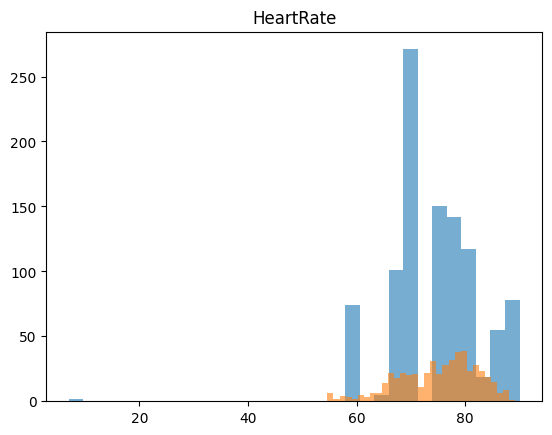

In [17]:
for col in numeric_cols:

    plt.hist(df[col].values, bins=31, alpha=0.6)
    plt.hist(synthetic_df[col].values, bins=31, alpha=0.6)
    plt.title(col, fontsize=12)
    
    plt.show()

# Make a loop

In [18]:
import itertools
from collections import defaultdict

import sklearn.metrics as skm

from sdv.single_table import GaussianCopulaSynthesizer

In [19]:
def generate_combinations(elements, sizes):
    comb_list = []
    for size in sizes:
        comb_list.extend(list(itertools.combinations(elements, size)))
    return comb_list

In [20]:
loss_method = ["median", "iqr", "autocorr", "corrmat", "covmat"]
sizes = np.arange(2, 3+1)
all_comb_list = generate_combinations(loss_method, sizes)
loss_method_list = ["-".join(x) for x in all_comb_list]
loss_method_list.extend(loss_method + ["all"])
print(loss_method_list)
print("Number of methods", len(loss_method_list))

['median-iqr', 'median-autocorr', 'median-corrmat', 'median-covmat', 'iqr-autocorr', 'iqr-corrmat', 'iqr-covmat', 'autocorr-corrmat', 'autocorr-covmat', 'corrmat-covmat', 'median-iqr-autocorr', 'median-iqr-corrmat', 'median-iqr-covmat', 'median-autocorr-corrmat', 'median-autocorr-covmat', 'median-corrmat-covmat', 'iqr-autocorr-corrmat', 'iqr-autocorr-covmat', 'iqr-corrmat-covmat', 'autocorr-corrmat-covmat', 'median', 'iqr', 'autocorr', 'corrmat', 'covmat', 'all']
Number of methods 26


In [21]:
def post_process_data_with_metadata(data, custom_metadata_dict):
    custom_syn_df = data.copy()
    for col_name, col_type in custom_metadata_dict.items():
        if col_type == "integer":
            custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

    return custom_syn_df

In [22]:
def generate_synthetic_data(generator, scaler, df_columns, num_data_generate, data_dim):
    """Generates synthetic data using a GAN-based generator and denormalizes it."""
    z = torch.randn(num_data_generate, data_dim)
    synthetic_data = generator(z).detach().numpy()
    synthetic_data_denom = scaler.inverse_transform(synthetic_data)
    return pd.DataFrame(synthetic_data_denom, columns=df_columns)

def evaluate_generator_metrics(real_df, synthetic_df, metadata):
    """Evaluates synthetic data quality using a quality report."""
    quality_report = evaluate_quality(real_df, synthetic_df, metadata, verbose=False)
    return quality_report.get_score()

def evaluate_discriminator_metrics(discriminator, real_data, fake_data, sigmoid_th, metrics_skm_dict):
    """Evaluates discriminator performance using real and synthetic data."""
    both_data_torch = torch.cat((real_data, fake_data), dim=0)
    
    true_labels = np.concatenate((np.zeros(real_data.shape[0]), np.ones(fake_data.shape[0])))
    discriminator_score = discriminator(both_data_torch)
    
    disc_score_array = (discriminator_score.detach().numpy()[:, 0] > sigmoid_th).astype(int)

    return {k: skm_func(true_labels, disc_score_array) for k, skm_func in metrics_skm_dict.items()}

def generate_sdv_synthetic_data(df, num_data_generate):
    """Generates synthetic data using SDV GaussianCopulaSynthesizer."""
    sdv_metadata = Metadata.detect_from_dataframe(data=df, table_name='maternal_metadata')
    synthesizer = GaussianCopulaSynthesizer(sdv_metadata)
    synthesizer.fit(data=df)
    return synthesizer.sample(num_rows=num_data_generate), sdv_metadata

In [ ]:
metrics_skm_dict = {
    "accuracy": skm.accuracy_score,
    "kappa": skm.cohen_kappa_score,
    "f1_score": skm.f1_score
}

num_epochs = 5000
batch_size = 64
num_generate_th = 30
num_data_generate = 500
sigmoid_th = 0.5

save_result_list = []

for loss_method in loss_method_list[:]:

    print(loss_method)
    
    all_real_data_torch = torch.tensor(data, dtype=torch.float32)

    generator = EncoderDecoderGenerator(in_out_dim=data_dim, latent_dim=16)
    optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)
    
    discriminator = Discriminator(input_dim=data_dim)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-3)
    
    criterion = nn.BCELoss()
    
    for epoch in range(num_epochs):
        
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data_array = data[idx]
        real_data = torch.tensor(data[idx], dtype=torch.float32)
        
        # Generar datos falsos
        z = torch.randn(batch_size, data_dim)
        fake_data = generator(z)
    
        if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
            print("Fake data contains NaNs or Infs!")
            break
    
        if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
            print("Real data contains NaNs or Infs!")
            break
        
        # Entrenar Discriminador
        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
        fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()
    
        # Entrenar Generador
        optimizer_g.zero_grad()
        g_loss = custom_loss(fake_data, all_real_data_torch, method=loss_method)
        g_loss.backward()
        # g_loss.backward()
        optimizer_g.step()

    # #####################
    # ### Generate data ###
    # #####################
    metrics_dict = defaultdict(list)
    for _ in range(num_generate_th):
        # Generate and process GAN-based synthetic data
        synthetic_df = generate_synthetic_data(generator, scaler, df.columns, num_data_generate, data_dim)
        custom_syn_df = post_process_data_with_metadata(synthetic_df, custom_metadata_dict)

        # Generator Metrics
        qr_score = evaluate_generator_metrics(df[numeric_cols], custom_syn_df, metadata)
        metrics_dict["qr_score"].append(qr_score)

        # Discriminator Metrics
        real_data_tensor = torch.tensor(data[np.random.randint(0, data.shape[0], num_data_generate)], dtype=torch.float32)
        fake_data_tensor = torch.tensor(synthetic_df.values, dtype=torch.float32)
        
        disc_metrics = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics.items():
            metrics_dict[k].append(v)

        # #####################
        # ### SDV Generator ###
        # #####################
        # Generate and process SDV-based synthetic data
        synthetic_df_sdv, sdv_metadata = generate_sdv_synthetic_data(df, num_data_generate)
        custom_syn_df_sdv = synthetic_df_sdv.copy()

        # Generator Metrics for SDV
        qr_score_sdv = evaluate_generator_metrics(df[numeric_cols], custom_syn_df_sdv, sdv_metadata)
        metrics_dict["sdv_qr_score"].append(qr_score_sdv)

        # Discriminator Metrics for SDV
        fake_data_tensor_sdv = torch.tensor(synthetic_df_sdv.values, dtype=torch.float32)
        disc_metrics_sdv = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor_sdv, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics_sdv.items():
            metrics_dict[f"sdv_{k}"].append(v)

    del generator, discriminator, optimizer_g, optimizer_d, criterion
    
    dict_help = {"loss_method": loss_method}
    for k, v in metrics_dict.items():
        dict_help[f"mean_{k}"] = np.mean(v)
        dict_help[f"std_{k}"] = np.std(v)
        
    save_result_list.append(dict_help)

In [24]:
df_results = pd.DataFrame(save_result_list).sort_values("mean_qr_score", ascending=False).reset_index(drop=True)
df_results.head(10)

,loss_method,mean_qr_score,std_qr_score,mean_accuracy,std_accuracy,mean_kappa,std_kappa,mean_f1_score,std_f1_score,mean_sdv_qr_score,std_sdv_qr_score,mean_sdv_accuracy,std_sdv_accuracy,mean_sdv_kappa,std_sdv_kappa,mean_sdv_f1_score,std_sdv_f1_score
0,median-corrmat-covmat,0.853393,0.002200,0.492300,0.013034,-0.015400,0.026067,0.200938,0.041468,0.852142,1.110223e-16,0.526100,0.012427,0.052200,0.024853,0.182714,0.037921
1,median-iqr-corrmat,0.849436,0.002827,0.550800,0.017741,0.101600,0.035483,0.531922,0.020041,0.852142,1.110223e-16,0.550867,0.019546,0.101733,0.039092,0.531783,0.015498
2,median-corrmat,0.847173,0.002323,0.539467,0.013283,0.078933,0.026567,0.285152,0.027347,0.852142,1.110223e-16,0.518867,0.019809,0.037733,0.039617,0.312966,0.028315
3,all,0.846712,0.002546,0.419000,0.021125,-0.162000,0.042250,0.369163,0.025799,0.852142,1.110223e-16,0.413833,0.019272,-0.172333,0.038544,0.354091,0.021977
4,median-autocorr-corrmat,0.841734,0.001959,0.539467,0.009701,0.078933,0.019403,0.185488,0.030753,0.852142,1.110223e-16,0.548433,0.016374,0.096867,0.032748,0.321553,0.031777
5,median-iqr-covmat,0.810965,0.003720,0.583667,0.013622,0.167333,0.027244,0.524912,0.015955,0.852142,1.110223e-16,0.545267,0.025301,0.090533,0.050602,0.536749,0.020674
6,median-autocorr-covmat,0.792400,0.003438,0.504367,0.003996,0.008733,0.007991,0.047309,0.012571,0.852142,1.110223e-16,0.521333,0.009931,0.042667,0.019862,0.126233,0.036339
7,median-covmat,0.766874,0.002999,0.458567,0.016554,-0.082867,0.033109,0.517936,0.024967,0.852142,1.110223e-16,0.430300,0.015069,-0.139400,0.030138,0.541173,0.016904
8,median-iqr,0.751220,0.002641,0.571767,0.014193,0.143533,0.028386,0.664803,0.009861,0.852142,1.110223e-16,0.593800,0.014824,0.187600,0.029649,0.682011,0.011191
9,median-iqr-autocorr,0.745923,0.002962,0.508133,0.019815,0.016267,0.039631,0.599162,0.012935,0.852142,1.110223e-16,0.507633,0.019527,0.015267,0.039054,0.611738,0.012388
